In [1]:
import torch
import os
from PIL import Image
import clip
import torch.nn.functional as F

In [2]:

image_model = torch.load('image_features_flickr8k.pt')

In [3]:
image_names = list(image_model.keys())
image_features = torch.stack(list(image_model.values()))

print(f"Number of images: {len(image_names)}")
print(f"Image features shape: {image_features.shape}")

Number of images: 8091
Image features shape: torch.Size([8091, 1, 512])


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [6]:
# Image to image
test_image_feature = []
# Get the path of the image you want to test
test_image_path = "test.jpg"
# Covert the image to a RGB image
test_image = Image.open(test_image_path).convert("RGB")
# prepocess the image and move it to the device
test_image_preprocessed = preprocess(test_image).unsqueeze(0).to(device)
# Get the image feature using the model.encode_image function
with torch.no_grad():
    test_image_feature = model.encode_image(test_image_preprocessed) # output shape torch.Size([1, 512])
# Normalize the image feature
    test_image_feature /= test_image_feature.norm(dim=-1, keepdim=True)
test_image_feature.shape # torch.Size([1, 512])

torch.Size([1, 512])

In [7]:
print(test_image_feature.shape)     #torch.Size([1, 1, 512])
print(image_features.squeeze(1).shape) #torch.Size([8091, 1, 512])

torch.Size([1, 512])
torch.Size([8091, 512])


In [8]:
image_names[0]


'997722733_0cb5439472.jpg'

torch.Size([8091])
tensor([ 581, 2593, 4792,  873, 7853])
torch.Size([5])
49553964_cee950f3ba.jpg
3413973568_6630e5cdac.jpg
2894576909_99c85fd7a7.jpg
418667611_b9995000f4.jpg
1280320287_b2a4b9b7bd.jpg


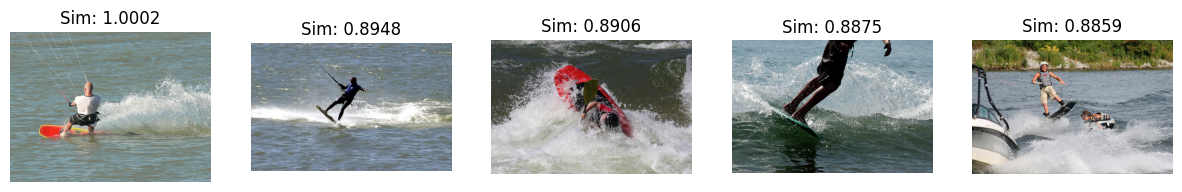

In [9]:
sims = F.cosine_similarity(test_image_feature, image_features.squeeze(1)).squeeze()
print(sims.shape)  #torch.Size([8091])
# Get the top 5 most similar images
topk = sims.topk(5).indices
# Display the top 5 most similar images
print(topk)
print(topk.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

retrieved_imgs = [image_names[j] for j in topk]

retrieved_imgs
for i, img_name in enumerate(retrieved_imgs):
    print(img_name)
    # img_path = os.path.join("./data/flickr30k/flickr30k_images/flickr30k_images/", img_name)
    img_path = os.path.join("../datasets/flickr8k/images/", img_name)
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sim: {sims[topk[i]]:.4f}")
